In [25]:
import torch 
import torch.nn as nn 
import torch.optim as optim



In [26]:
import urllib.request
import zipfile
import os

URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
ZIP_PATH = "UCI_HAR_Dataset.zip"
EXTRACT_DIR = "data"

if not os.path.exists(ZIP_PATH):
    print("Downloading UCI HAR dataset...")
    urllib.request.urlretrieve(URL, ZIP_PATH)


if not os.path.exists(os.path.join(EXTRACT_DIR, "UCI HAR Dataset")):
    print("Extracting dataset...")
    with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)

print("Done.")


Done.


In [27]:
import numpy as np
import os

BASE = "data/UCI HAR Dataset"

def load_har(split="train"):
    base = os.path.join(BASE, split, "Inertial Signals")
    signals = [
        "body_acc_x", "body_acc_y", "body_acc_z",
        "body_gyro_x", "body_gyro_y", "body_gyro_z",
        "total_acc_x", "total_acc_y", "total_acc_z",
    ]

    X = []
    for s in signals:
        X.append(
            np.loadtxt(os.path.join(base, f"{s}_{split}.txt"))
        )

    X = np.stack(X, axis=-1)              # (N, 128, 9)
    y = np.loadtxt(
        os.path.join(BASE, split, f"y_{split}.txt")
    ) - 1                                 # Labels 0..5

    return X.astype("float32"), y.astype("int32")


In [28]:
X_train, y_train = load_har("train")
X_test,  y_test  = load_har("test")

print(X_train.shape)  # (7352, 128, 9)
print(y_train.shape)  # (7352,)

mean = X_train.mean(axis=(0, 1), keepdims=True)
std  = X_train.std(axis=(0, 1), keepdims=True) + 1e-6

X_train = (X_train - mean) / std
X_test  = (X_test  - mean) / std


(7352, 128, 9)
(7352,)


In [29]:
y_train

array([4, 4, 4, ..., 1, 1, 1], shape=(7352,), dtype=int32)

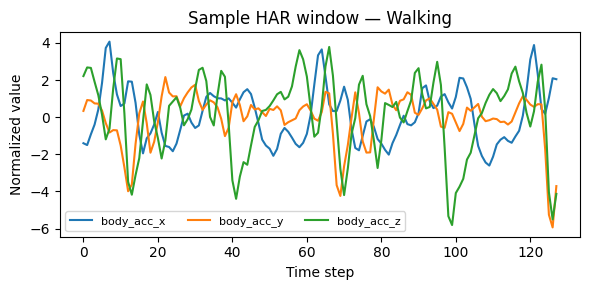

In [30]:
import matplotlib.pyplot as plt

class_names = [
    'Walking',
    'Walking Upstairs',
    'Walking Downstairs',
    'Sitting',
    'Standing',
    'Laying',
]

idx = 5000  # change to view a different sample
t = range(X_train.shape[1])
activity = class_names[int(y_train[idx])]

plt.figure(figsize=(6, 3))
plt.plot(t, X_train[idx, :, 0], label='body_acc_x')
plt.plot(t, X_train[idx, :, 1], label='body_acc_y')
plt.plot(t, X_train[idx, :, 2], label='body_acc_z')
plt.xlabel('Time step')
plt.ylabel('Normalized value')
plt.title(f'Sample HAR window — {activity}')
plt.legend(fontsize=8, ncol=3)
plt.tight_layout()
plt.show()


In [31]:
from torch.utils.data import TensorDataset, DataLoader

BATCH = 64
device = "mps" # mac -> mps, windows -> cpu 

train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train).long())
test_ds = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test).long())

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=False)


In [32]:
128*9*len(train_ds)

8469504

In [33]:
32*9*128 + 128

36992

In [34]:
class hRNN(nn.Module):
    def __init__(self, num_classes= 6, input_size = 9, hidden_size = 32): # 9 sensors, 6 classes, size of h_t is 32
        super().__init__()

        # two stages features + classifier

        # stage 1 RNN 
        self.rnn = nn.RNN(input_size, hidden_size , batch_first=True ) # if batch_first=False -> (128, BATCH, 9) 
                                                                       # if batch_first=True -> (BATCH, 128, 9 )
        
        # classifier 
        self.fc1 = nn.Linear(hidden_size, 128)
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        out, _ = self.rnn(x) # get hidden state
        out = out[:,-1,:] # flatten 
        out = torch.relu(self.fc1(out)) # classifier 
        out = self.drop(out)
        return self.fc2(out) # decision 

model = hRNN(input_size=9, hidden_size=32, num_classes=6).to(device)

In [35]:
loss = nn.CrossEntropyLoss() # because multi-class 
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3) # Adam = modern gradient-based method (roughly speaking)

epochs = 30
patience = 5 # 3-5-7 Patience is the number of consecutive epochs without improvement that we allow before training stops 
# usually improvement means lower validation loss 
# sometimes it is equal to test loss 
# sometimes you split the dataset in (train, val, test) and use val-part for computing validation loss
best_val_loss = float("inf") # 
patience_left = patience 
best_state = None 

for epoch in range(1, epochs+1):
    model.train()

    train_loss = .0
    train_correct = 0
    train_count = 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        # training
        optimizer.zero_grad()
        logits = model(xb) # expectation
        loss_out = loss(logits, yb) # expectation - reality 
        loss_out.backward()
        optimizer.step()
    
        batch_size = xb.size(0)
        train_loss += loss_out.item() * batch_size
        train_correct += (logits.argmax(dim=1)==yb).sum().item() # number of correctly classified
        train_count += batch_size

    train_loss /= train_count
    train_acc = train_correct/train_count

    model.eval() # test data
    val_loss = .0
    val_correct = 0
    val_count = 0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            loss_out = loss(logits,yb)
            batch_size = xb.size(0)
            val_loss += loss_out.item() * batch_size
            val_correct += (logits.argmax(dim=1)==yb).sum().item() # number of correctly classified
            val_count += batch_size

    val_loss /= val_count
    val_acc = val_correct/val_count

    print(
        f"Epoch {epoch} | train_loss= {train_loss:.4f} acc= {train_acc:.4f} |"
        f"val_loss= {val_loss:.4f} acc= {val_acc:.4f}"
    )

    if val_loss<best_val_loss - 1e-3:
        best_val_loss = val_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()} # save the weights 
        patience_left = patience
    else:
        patience_left -= 1
        if patience_left == 0:
            print("Early stopping")
            break

if best_state is not None:
    model.load_state_dict(best_state)


Epoch 1 | train_loss= 1.2321 acc= 0.5220 |val_loss= 0.8229 acc= 0.6451
Epoch 2 | train_loss= 0.7118 acc= 0.6722 |val_loss= 0.7083 acc= 0.6759
Epoch 3 | train_loss= 0.6062 acc= 0.7127 |val_loss= 0.7332 acc= 0.6997
Epoch 4 | train_loss= 0.5667 acc= 0.7465 |val_loss= 0.7079 acc= 0.7224
Epoch 5 | train_loss= 0.5337 acc= 0.7693 |val_loss= 0.6563 acc= 0.7333
Epoch 6 | train_loss= 0.6086 acc= 0.7466 |val_loss= 0.6771 acc= 0.6848
Epoch 7 | train_loss= 0.5446 acc= 0.7599 |val_loss= 0.6488 acc= 0.7411
Epoch 8 | train_loss= 0.5167 acc= 0.7826 |val_loss= 0.5868 acc= 0.7357
Epoch 9 | train_loss= 0.4633 acc= 0.7950 |val_loss= 0.5540 acc= 0.7584
Epoch 10 | train_loss= 0.4425 acc= 0.8078 |val_loss= 0.5001 acc= 0.7791
Epoch 11 | train_loss= 0.3891 acc= 0.8247 |val_loss= 0.4977 acc= 0.7910
Epoch 12 | train_loss= 0.5078 acc= 0.7779 |val_loss= 0.5731 acc= 0.7648
Epoch 13 | train_loss= 0.6262 acc= 0.7871 |val_loss= 0.8645 acc= 0.6939
Epoch 14 | train_loss= 0.5242 acc= 0.7807 |val_loss= 0.5140 acc= 0.7808
E

In [36]:
import numpy as np
from sklearn.metrics import confusion_matrix

model.eval()
all_logits = []

with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        all_logits.append(logits.cpu().numpy())

logits = np.concatenate(all_logits, axis=0)
y_pred = np.argmax(logits, axis=1)

cm = confusion_matrix(y_test, y_pred)
cm


array([[363, 125,   6,   0,   2,   0],
       [ 91, 353,  24,   2,   1,   0],
       [ 23,  31, 364,   0,   2,   0],
       [  0,   3,   0, 374, 114,   0],
       [  2,   1,   0, 102, 427,   0],
       [  0,   0,  16,   0,   0, 521]])

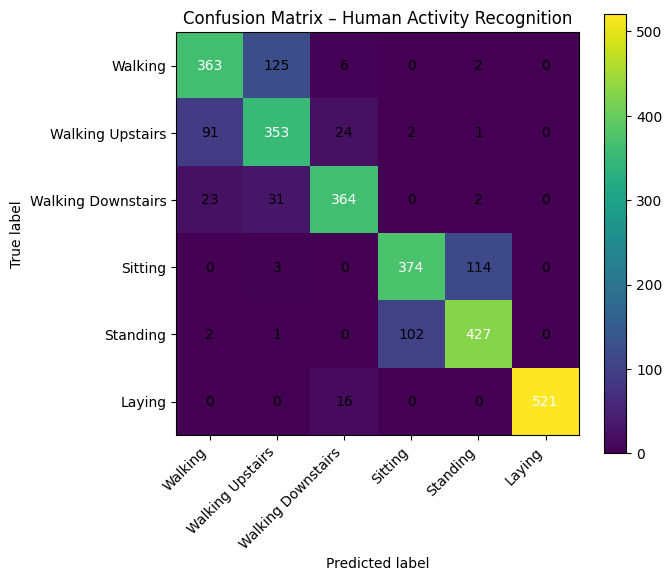

In [37]:
import matplotlib.pyplot as plt

class_names = [
    "Walking",
    "Walking Upstairs",
    "Walking Downstairs",
    "Sitting",
    "Standing",
    "Laying",
]

fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(cm)

ax.set_xticks(range(len(class_names)))
ax.set_yticks(range(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticklabels(class_names)

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion Matrix – Human Activity Recognition")

# Werte einzeichnen
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2 else "black")

fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()
